# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import datetime
import matplotlib.gridspec as gd
from tabulate import tabulate
from scipy import stats

In [2]:
df_sales_raw = pd.read_csv('database/train.csv', low_memory=False)
df_stores_raw = pd.read_csv('database/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_stores_raw, how='left', on='Store')

## 0.1. Helper Functions 

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum() 
    r, k = cm.shape  #rows ands columns
    
    chi2 = stats.chi2_contingency(cm)[0] #only first result of chiˆ2
    
    #bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def jupyter_settings():
    # Global configuration
    %matplotlib inline
    
    sns.set_theme()                                                   
    plt.rcParams['figure.figsize'] = [20, 12]

## Loading data

In [4]:
jupyter_settings()
df1 = df_raw.copy()

# 1.0. DATA DESCRIPTION

## 1.1. Rename Columns

In [5]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print(f'Number of rows: {df1.shape[0]} \nNumber of collumns: {df1.shape[1]}')

Number of rows: 1017209 
Number of collumns: 18


## 1.3.  Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'], format='%Y-%m-%d')
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
# competition_distance

    # df1['competition_distance'].max()
    # Verifying maximum value

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.00 if math.isnan(x) else x)


# competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year

df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week

df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# promo2_since_year

df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['month_map','promo_interval']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

## 1.6. Checking Types 

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical 

In [13]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

### 1.7.1 Numerical attributes

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersiom - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


m = pd.concat([ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [15]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical attributes

In [16]:
cat_attributes.apply(lambda x : x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

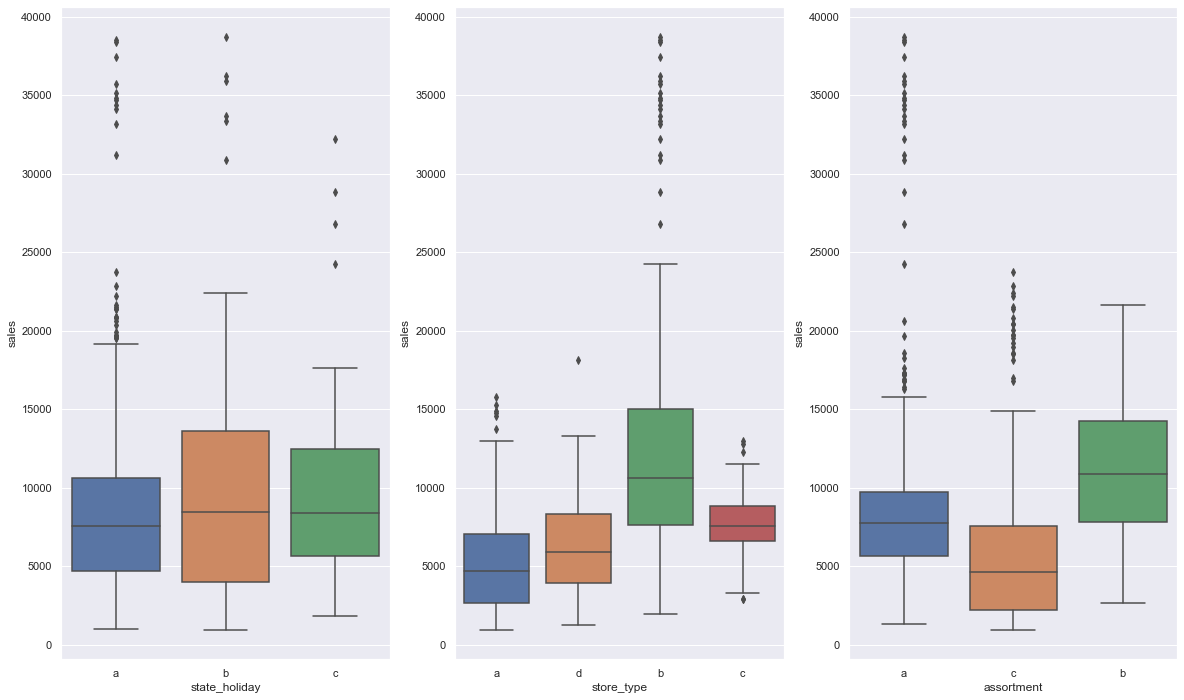

In [17]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Global configuration
sns.set_theme()                                                   
plt.rcParams['figure.figsize'] = [20, 12]     

plt.subplot(1,3,1)
f1 = sns.boxplot(x='state_holiday', y='sales', data = aux1)

plt.subplot(1,3,2)
f2 = sns.boxplot(x='store_type', y='sales', data = aux1)

plt.subplot(1,3,3)
f3 = sns.boxplot(x='assortment', y='sales', data = aux1)

# 2.0. FEATURE ENGINEERING

In [18]:
df2 = df1.copy()

## 2.1. Mindmap Mental Hypothesis

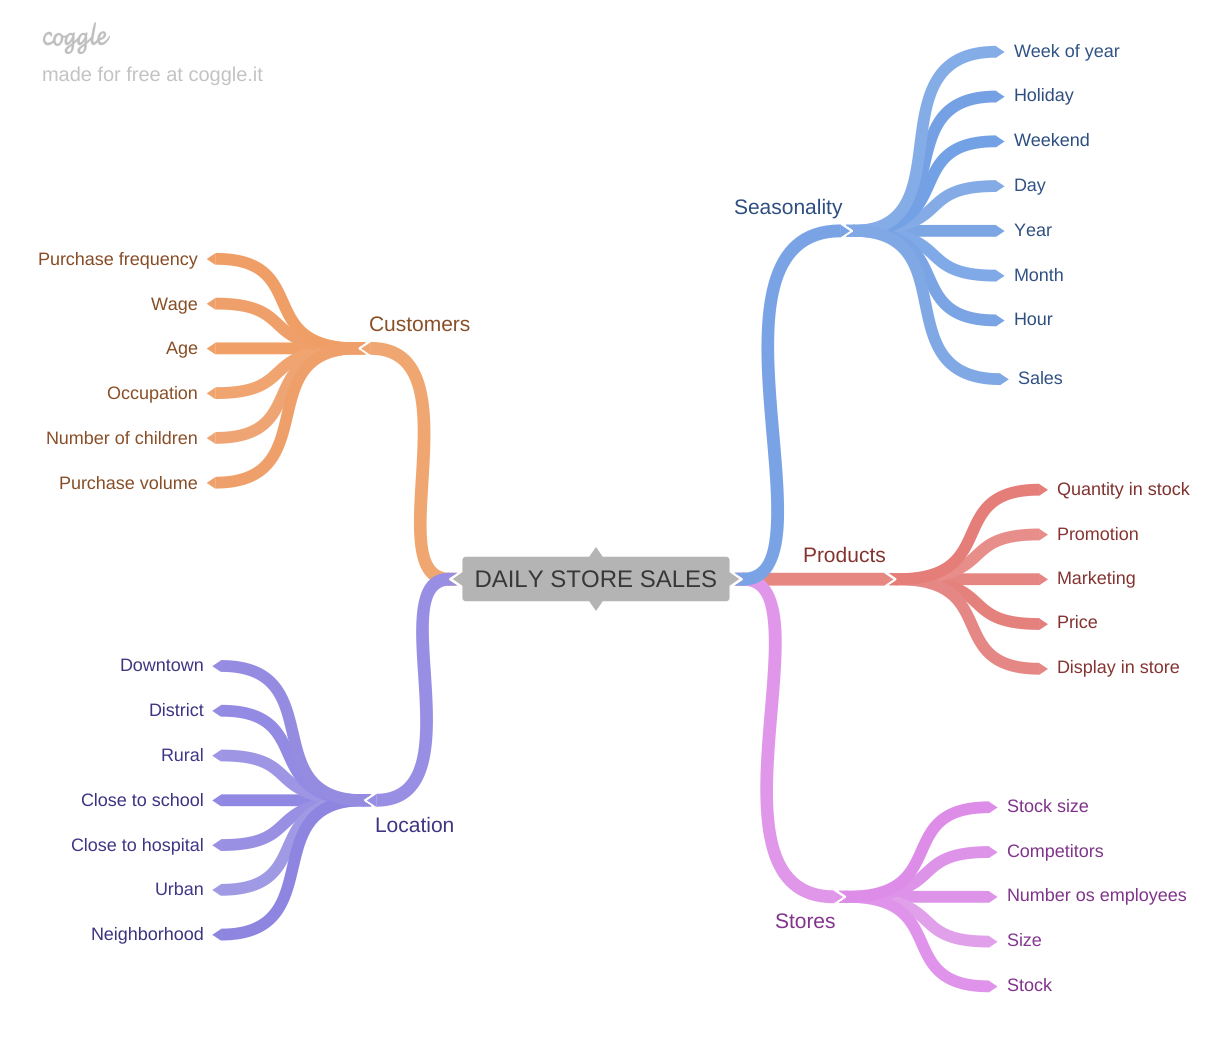

In [19]:
Image('img/MindMapHypothesis.png')

## 2.2. Hypothesis Creation

### 2.2.1. Store Hypothesis 


**1.** Stores with more employeees should sell more;

**2.** Stores with more stock should selll more;

**3.** Biggest stores should sell more;

**4.** Larger stock assortment should sell more;

**5.** Near competition makes sell less;

**6.** Stores with older competitors should sell more.

### 2.2.2. Product Hypothesis

**1.** Stores wich have more marketing budget should sell more;

**2.** Stores with more showcases should sell more;

**3.** Smaller prices stores should sell more;

**4.** Agrressive promotions should sell more;

**5.** Long time promotions should sell more;

**6.** Oldest promotions should sell more;

**7.** Consecutive promotions should sell more

### 2.2.3. Time Hypothesis 

**1.** During the Christmas stores should sell more;

**2.** Stores should sell more passing the years;

**3.** Stores opened during second half should sell more;

**4.** Stores should sell more after the 10th day from each month;

**5.** Stores should sell less during the weekend;

**6.** Stores should sell less during schoolarship holidays;



## 2.3. Hypothesis Final List



**1.** Stores with more stock should selll more;

**2.** Near competition makes sell less;

**3.** Stores with older competitors should sell more.

**4.** Long time promotions should sell more;

**5.** Oldest promotions should sell more;

**6.** Conescutive promotions should sell more.

**7.** During the Christmas stores should sell more;

**8.** Stores should sell more passing the years;

**9.** Stores opened during second half should sell more;

**10.** Stores should sell more after the 10th day from each month;

**11.** Stores should sell less during the weekend;

**12.** Stores should sell less during schoolarship holidays.

## 2.4. Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x : datetime.datetime(x['competition_open_since_year'], x['competition_open_since_month'],1), axis=1) #setting first day of each month in each year
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x : x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) #changing into str type to be able to concat/join two variables
# have to turn 'promo_since' into columns again to be able to calculate between datetime columns
df2['promo_since'] = df2['promo_since'].apply(lambda x : datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7)) #subtract 7 days to reach the beginning of year week
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x : x.days).astype(int) #dividing by 7 to turn the variable into weeks

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a' else 'extra'if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


/var/folders/ym/6_7bbw9s6cj8v1r0df3rdb_c0000gn/T/ipykernel_77014/2845442081.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [21]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. VARIABLES FILTERING

In [22]:
df3 = df2.copy()

## 3.1. Rows filtering

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns selection 

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(columns=cols_drop)
# or
# df3 = df3.drop(cols_drop, axis = 1)

# 4.0. EXPLORATORY DATA ANALYSIS 

In [25]:
df4 = df3.copy()

## 4.1. Univariate analysis 

### 4.1.1. Response variable

/Users/diogodamastadnik/.pyenv/versions/3.10.5/envs/RossmannSalesStore/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

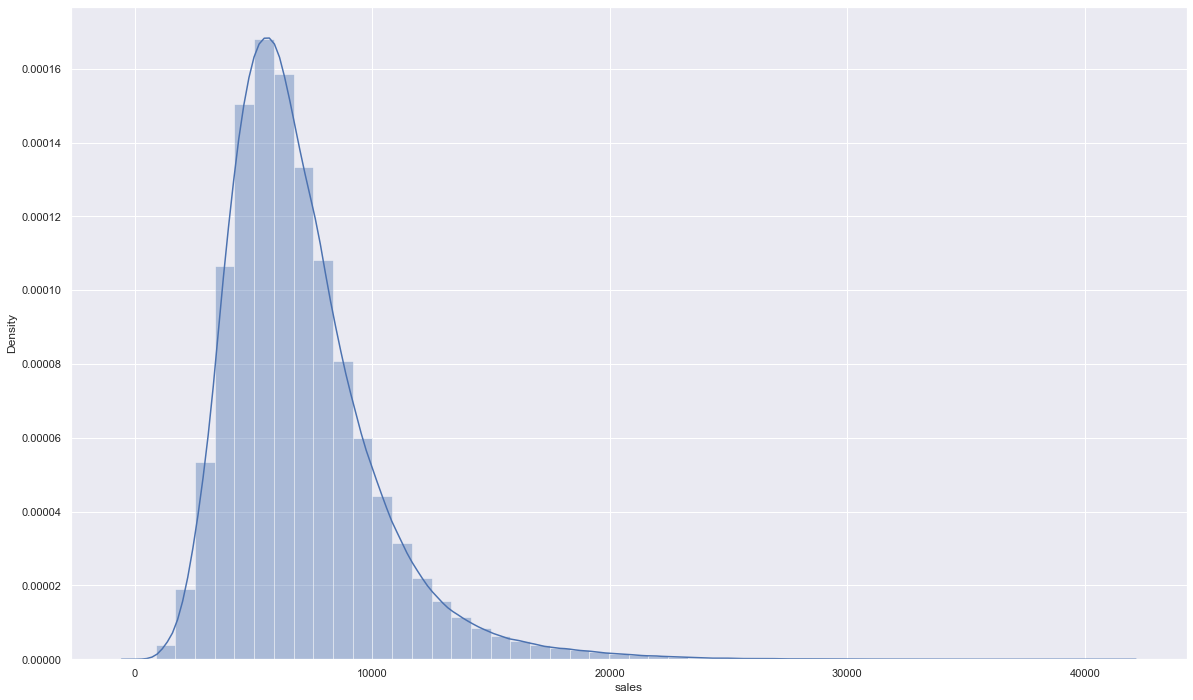

In [26]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical variable 

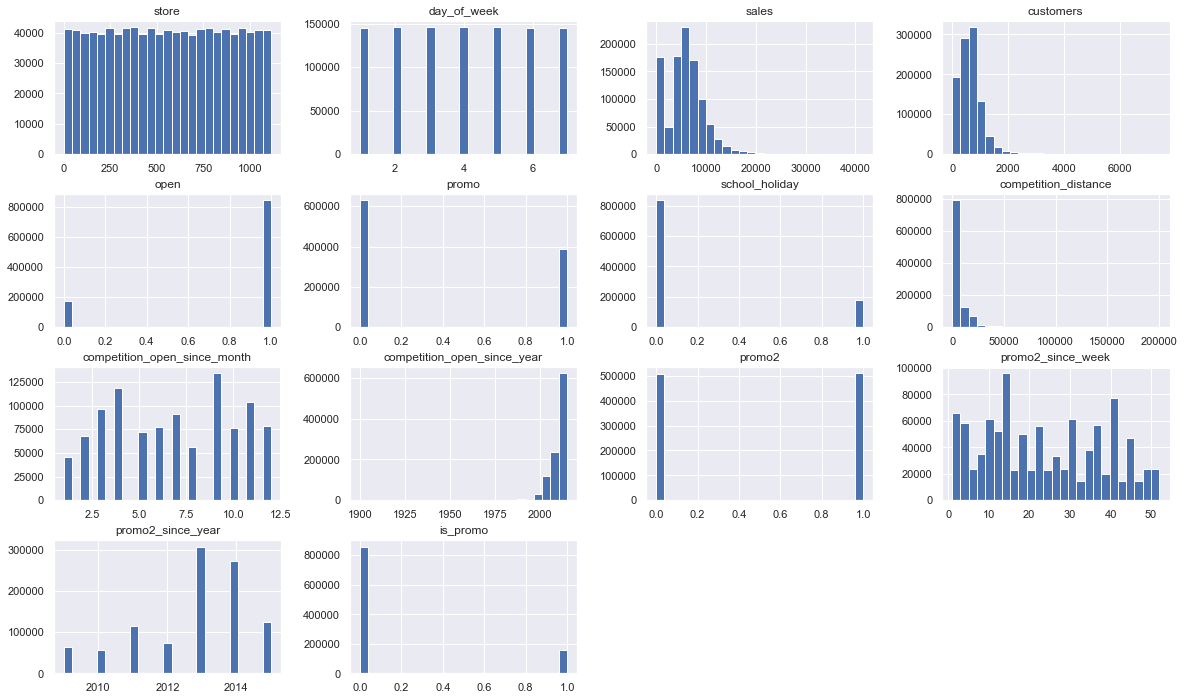

In [27]:
num_attributes.hist(bins=25);

### 4.1.3. Catagoical variable 

/Users/diogodamastadnik/.pyenv/versions/3.10.5/envs/RossmannSalesStore/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/diogodamastadnik/.pyenv/versions/3.10.5/envs/RossmannSalesStore/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/diogodamastadnik/.pyenv/versions/3.10.5/envs/RossmannSalesStore/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argu

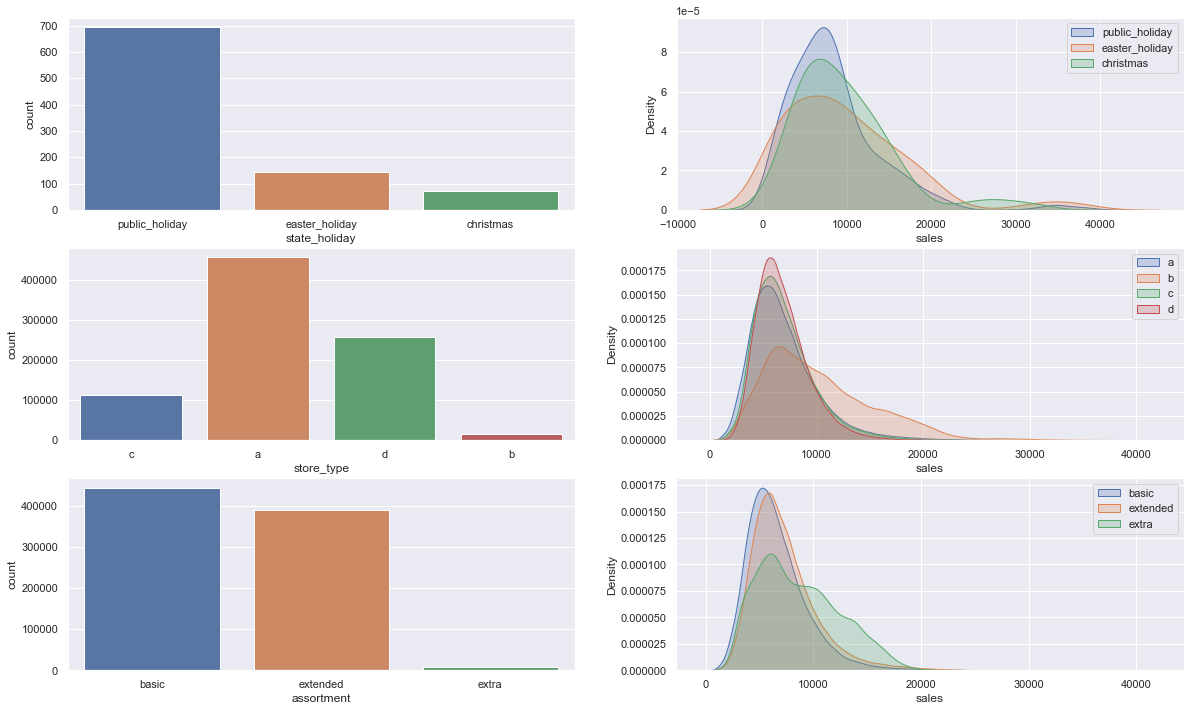

In [28]:
# state_holiday

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade=True)
plt.legend(labels=['public_holiday','easter_holiday', 'christmas'])


# store_type

plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade=True)
plt.legend(labels=['a', 'b', 'c', 'd'])


# assortment

plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade=True)
plt.legend(labels=['basic', 'extended', 'extra'])



## 4.2. Bivariate analysis 

### **H1.** Stores with more stock should selll more

**FALSE** - BIGGEST ASSORTMENT stores sell LESS (70,946,312 sales)

,assortment,sales
0,extra,70946312


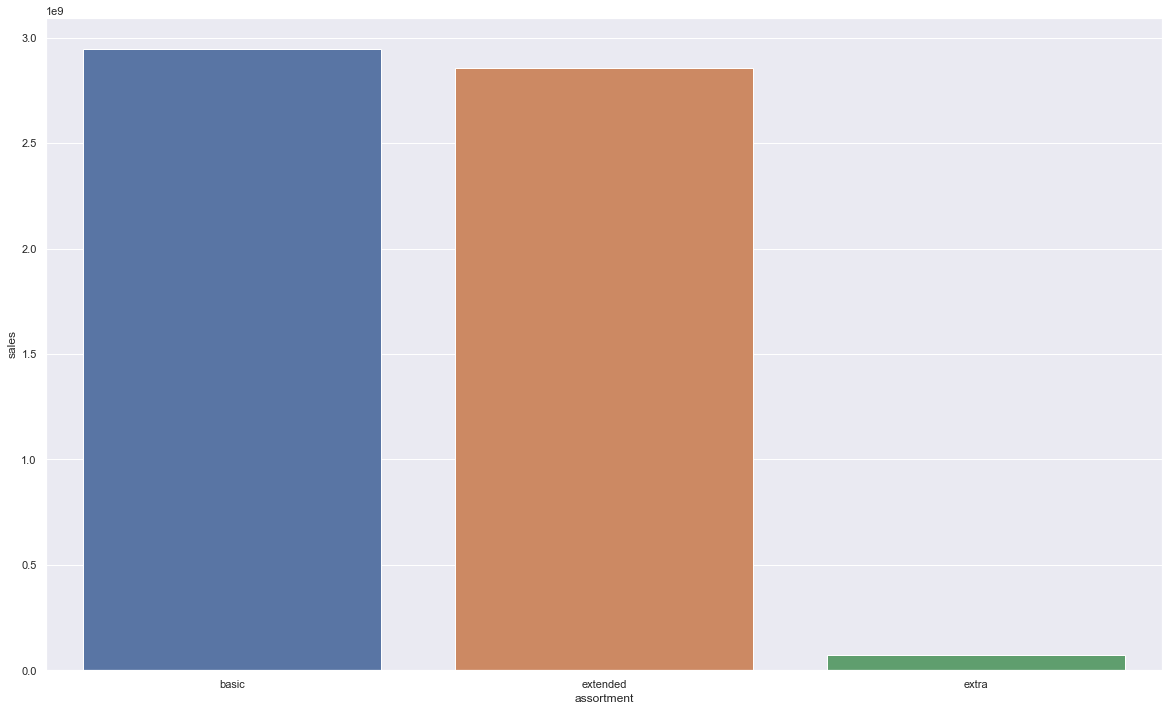

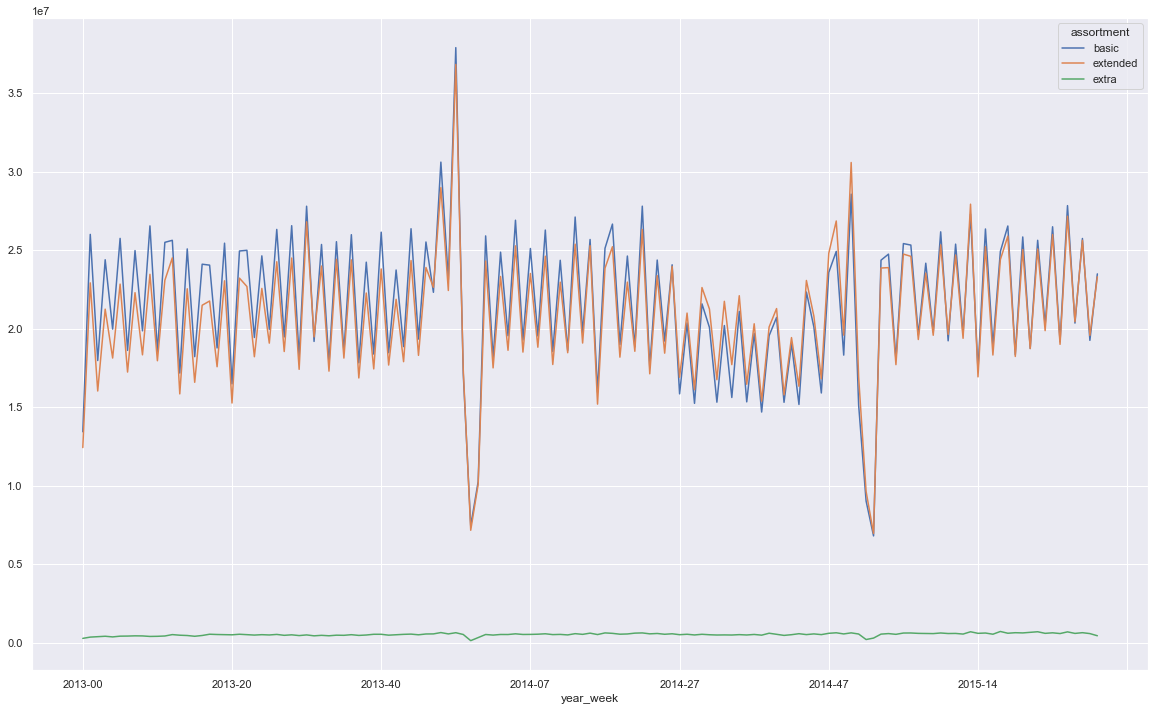

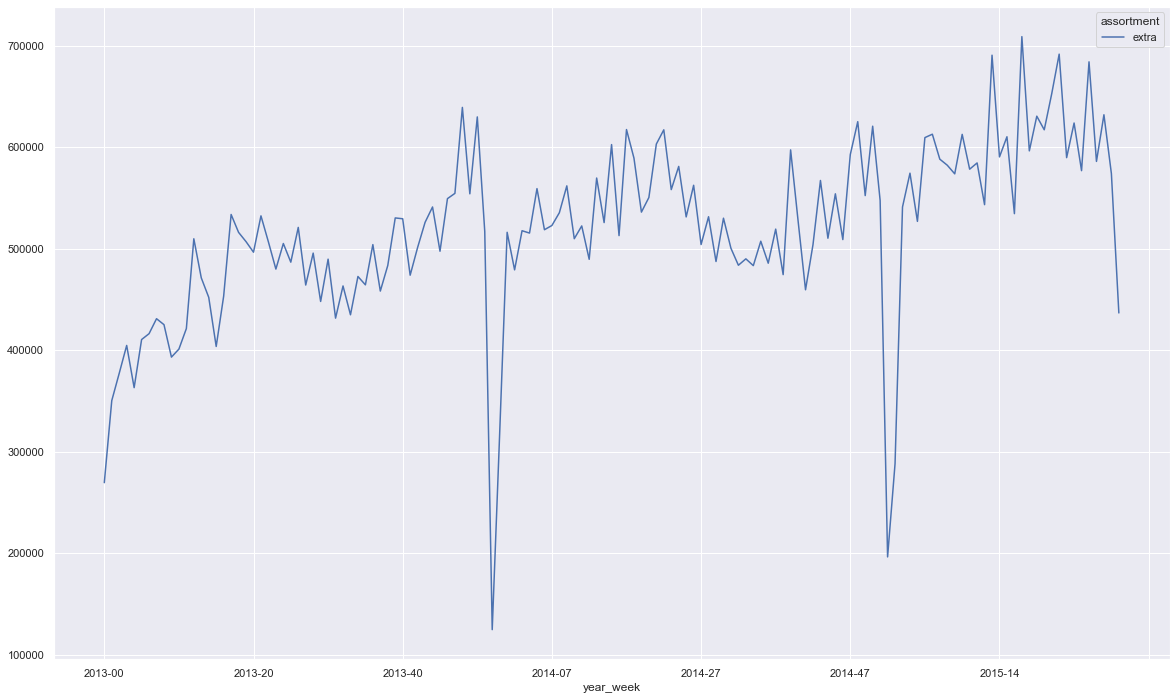

In [29]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(data = aux1, x='assortment', y='sales');

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = df4[df4['assortment'] == 'extra'][['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

extra = df4[df4['assortment'] == 'extra'][['assortment', 'sales']].groupby([ 'assortment']).sum().reset_index()
extra

### **H2.** Near competition makes less sales
**FALSE** - In fact, stores with COMPETITORS NEARBY sell MORE

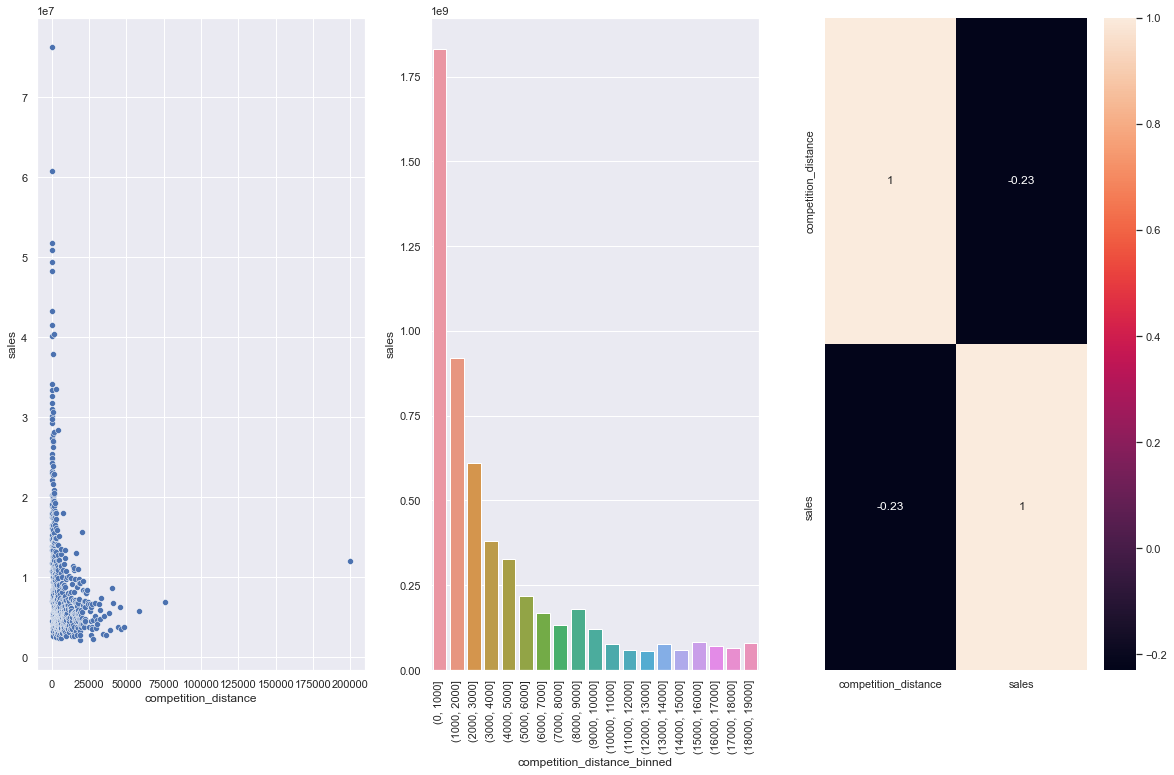

In [30]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(data=aux1 , x = 'competition_distance', y='sales')

plt.subplot(1, 3, 2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
plt.xticks(rotation=90)

# showing correlation
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True);

Closer competition entails more sales

-0.23 correlation between competition distance and sales

### **H3.** Stores with older competitors should sell more.
**FALSE** - Stores with OLDER COMPETITORS sell LESS. 

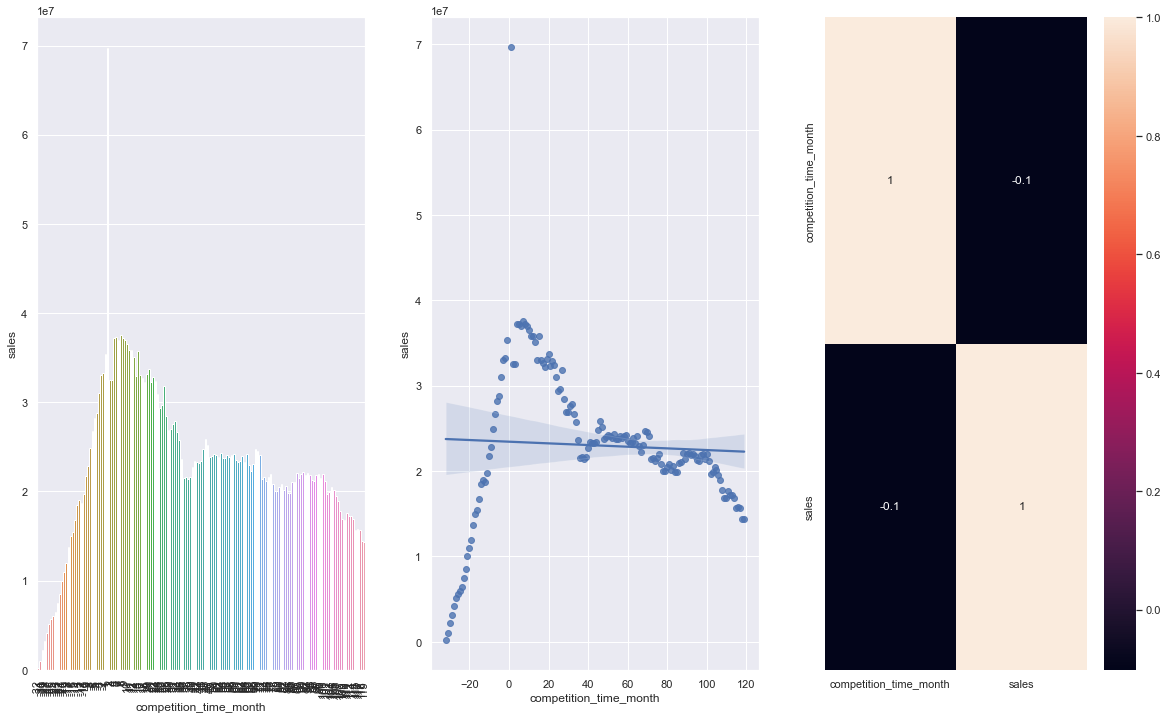

In [31]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)] #assumption
sns.barplot(data=aux2, x='competition_time_month', y = 'sales');
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(data=aux2, x='competition_time_month', y = 'sales');

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

As seen in the first chart, the more recent the competition, more sales will occur

-0.1 correlation between competition time (in months) and sales

### H4.  Long time promotions should sell more
**FALSE** - The store regularly sell up to a certain period

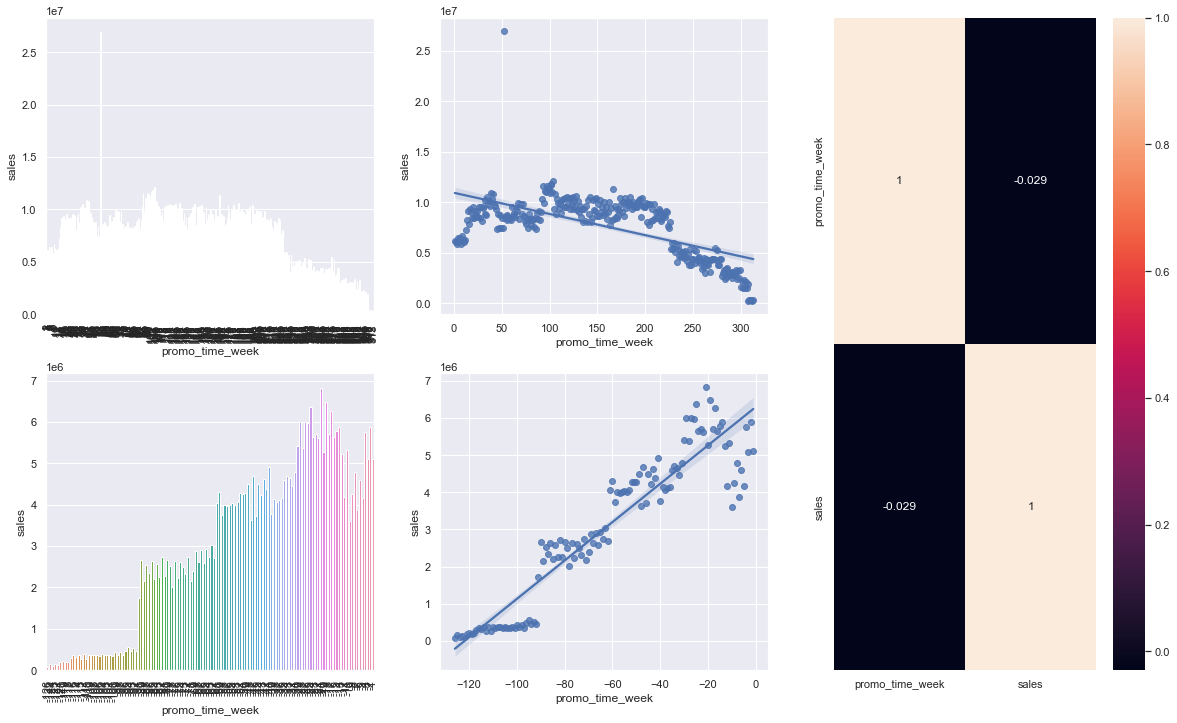

In [32]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(data=aux1, x='promo_time_week', y='sales');

grid = gd.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #extended promo
sns.barplot(data=aux2, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(data=aux2, x='promo_time_week', y='sales');


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #regular promo
sns.barplot(data=aux3, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales');

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Extended promo has a period wich sells better. The promo effect no longer works so well.

On the other hand, about a year and a half before the new promotion starts, the sales start increase

-0.029 correlation between promo time (in weeks) and sales. No relationship - Steady period is longer than the falling period

### <s>H5. Oldest promotions should sell more.</s>

### H6. Consecutive promotions should sell more 
**FALSE** - In fact, consecutive promotions sells less.

In [33]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()
# checking when  have the most sales, the highest volume is when only regular promotion occurs

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


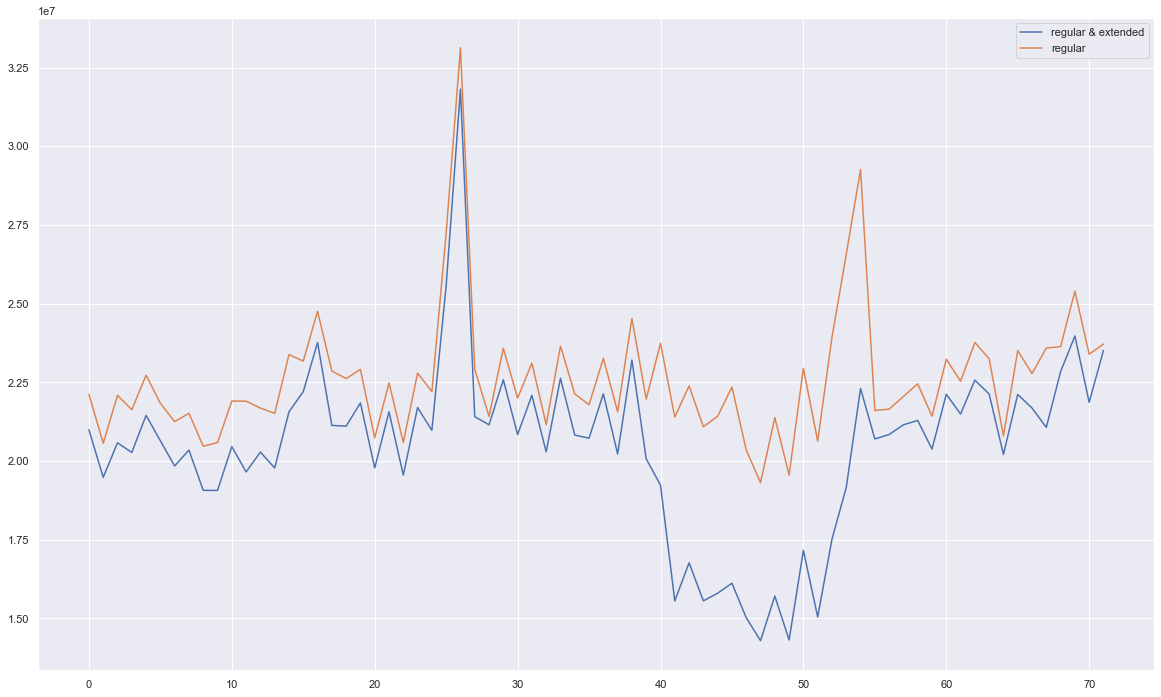

In [34]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()


aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax) #plot the first chart on the same grid as the second chart

plt.legend(labels = ['regular & extended', 'regular']); #setting legend labels


### H7. During the Christmas stores should sell more
**FALSE** - Stores sell more in public holidays

<AxesSubplot:xlabel='year', ylabel='sales'>

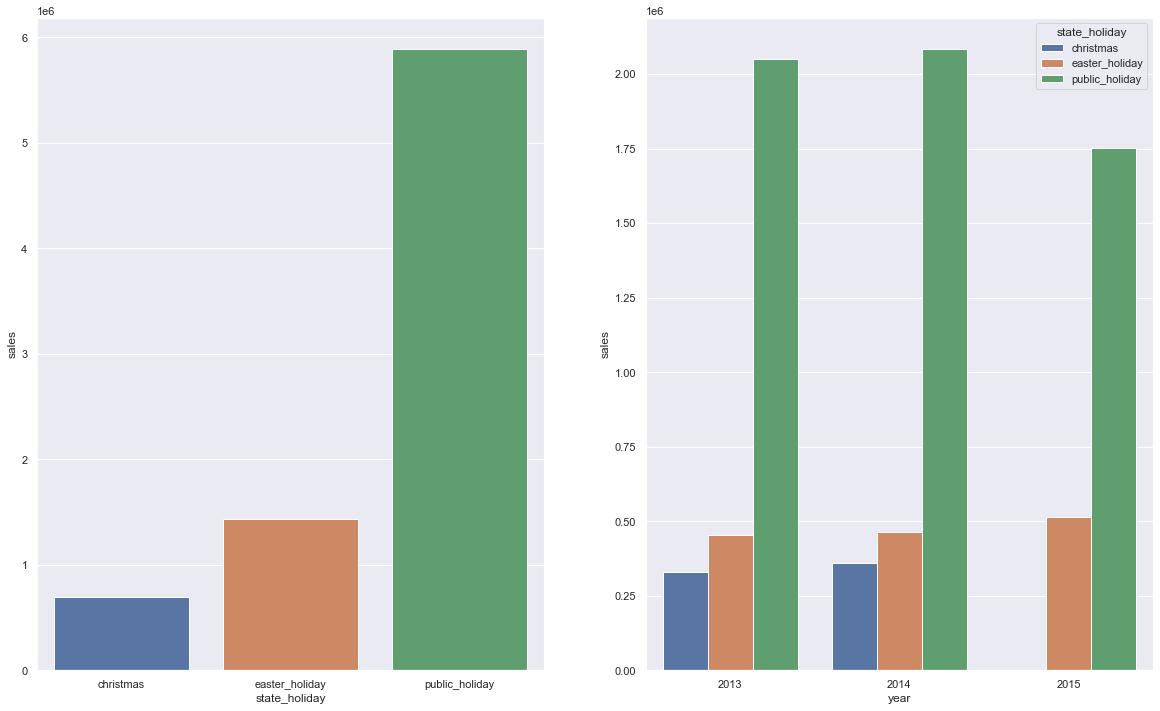

In [35]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data= aux1, x='state_holiday', y='sales')

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday')

### H8. Stores should sell more passing the years
**FALSE** - Sales have been decresing over the years

<AxesSubplot:>

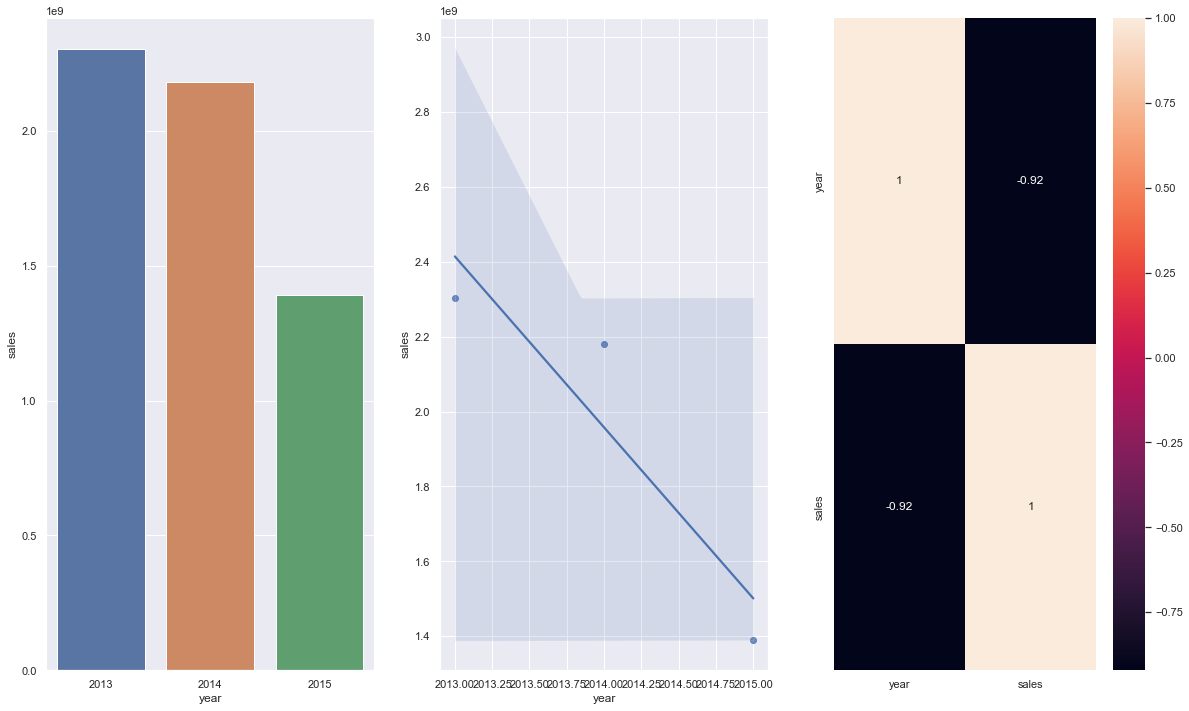

In [36]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data= aux1, x='year', y='sales')

plt.subplot(1,3,2)
sns.regplot(data= aux1, x='year', y='sales')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr('pearson'), annot= True)

-0.92 correlation between year and sales, but be carreful: 2015 ins't over yet to be calculated in correlation

### H9. Stores opened during second half should sell more
**FALSE** - Sales fall on second half

<AxesSubplot:>

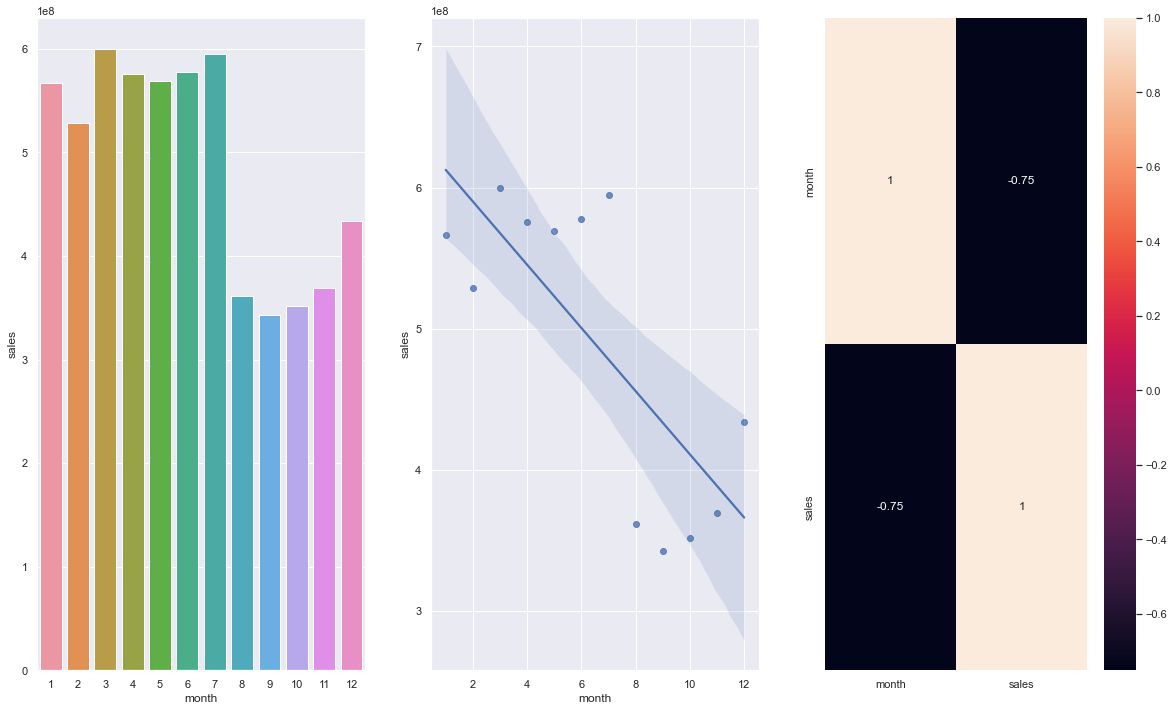

In [37]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(data= aux1, x='month', y='sales')

plt.subplot(1,3,2)
sns.regplot(data= aux1, x='month', y='sales')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr('pearson'), annot= True)


### H10. Stores should sell more after the 10th day from each month
**TRUE** - Stores sell more, accumulated, after 10 first days

<AxesSubplot:xlabel='before_after', ylabel='sales'>

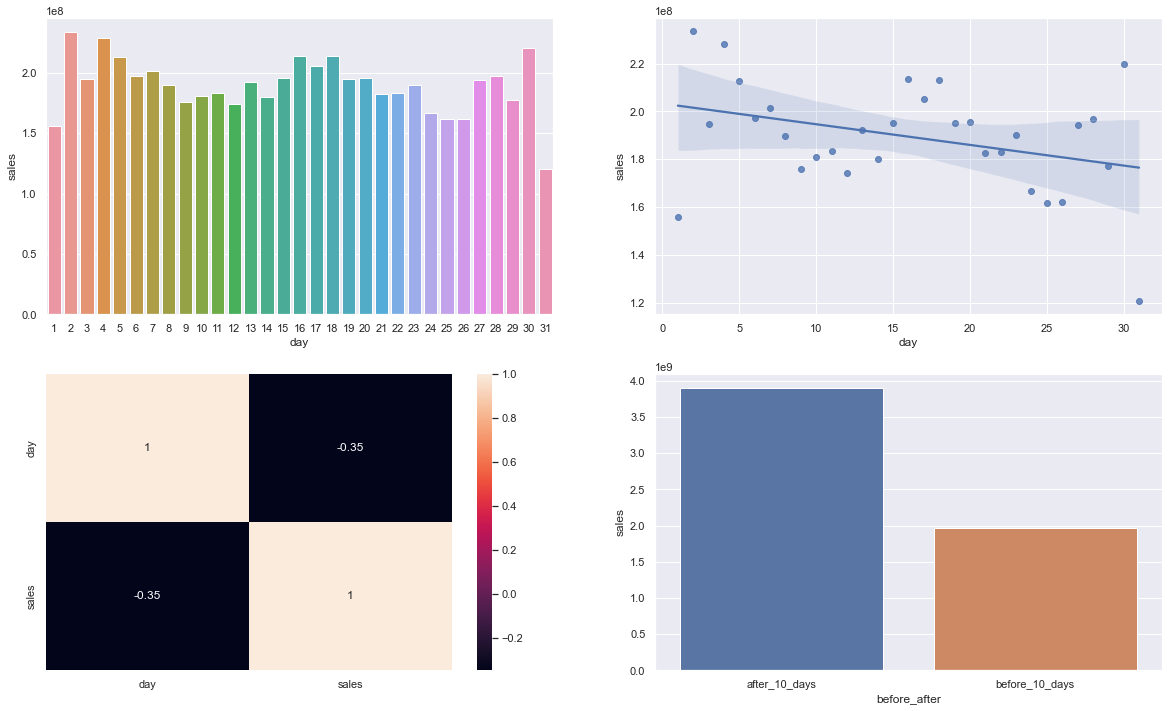

In [38]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
aux1['before_after'] = aux1['day'].apply(lambda x : 'before_10_days' if x <= 10 else 'after_10_days')

aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
 

plt.subplot(2,2,1)
sns.barplot(data= aux1, x='day', y='sales')

plt.subplot(2,2,2)
sns.regplot(data= aux1, x='day', y='sales')

plt.subplot(2,2,3)
sns.heatmap(aux1.corr('pearson'), annot= True)

plt.subplot(2,2,4)
sns.barplot(data= aux2, x='before_after', y='sales')

### H11. Stores should sell less during the weekend
**TRUE** - Stores sell more during working weeks

<AxesSubplot:>

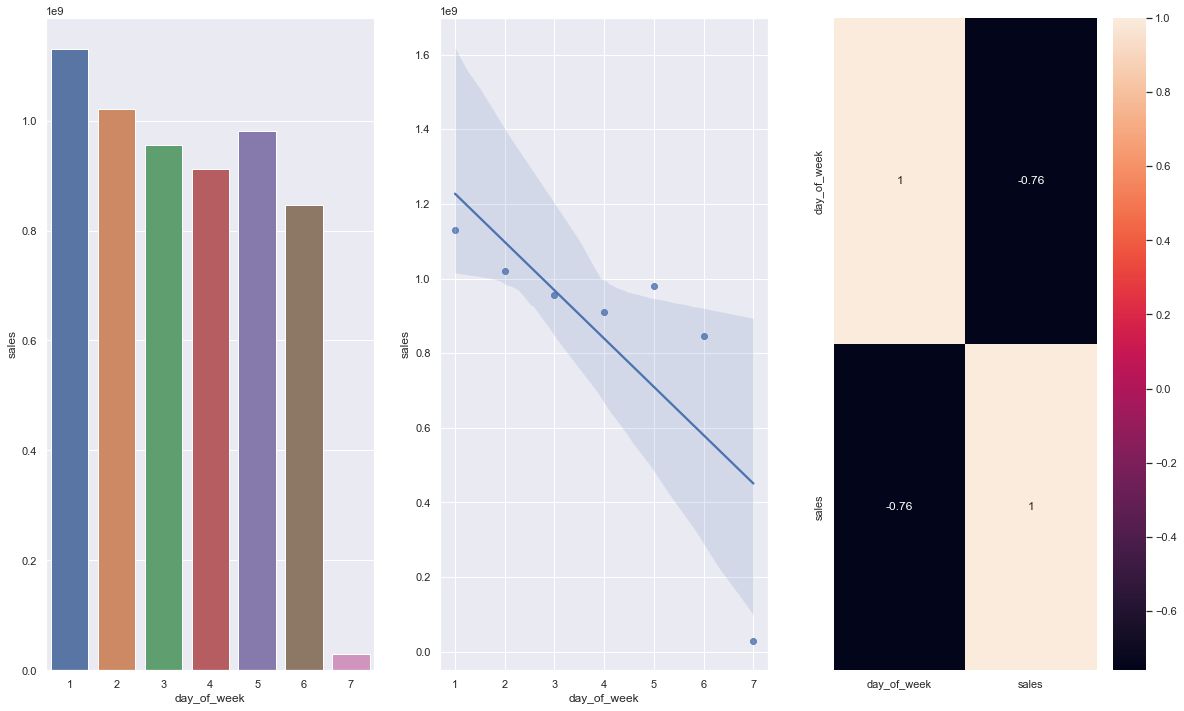

In [39]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(data=aux1, x='day_of_week', y='sales')

plt.subplot(1,3,1)
sns.barplot(data= aux1, x='day_of_week', y='sales')

plt.subplot(1,3,2)
sns.regplot(data= aux1, x='day_of_week', y='sales')

plt.subplot(1,3,3)
sns.heatmap(aux1.corr('pearson'), annot= True)


### H12. Stores should sell less during schoolarship holidays
**TRUE** - Stores sell more during regular days execpt in July and August, because it's summer vacation

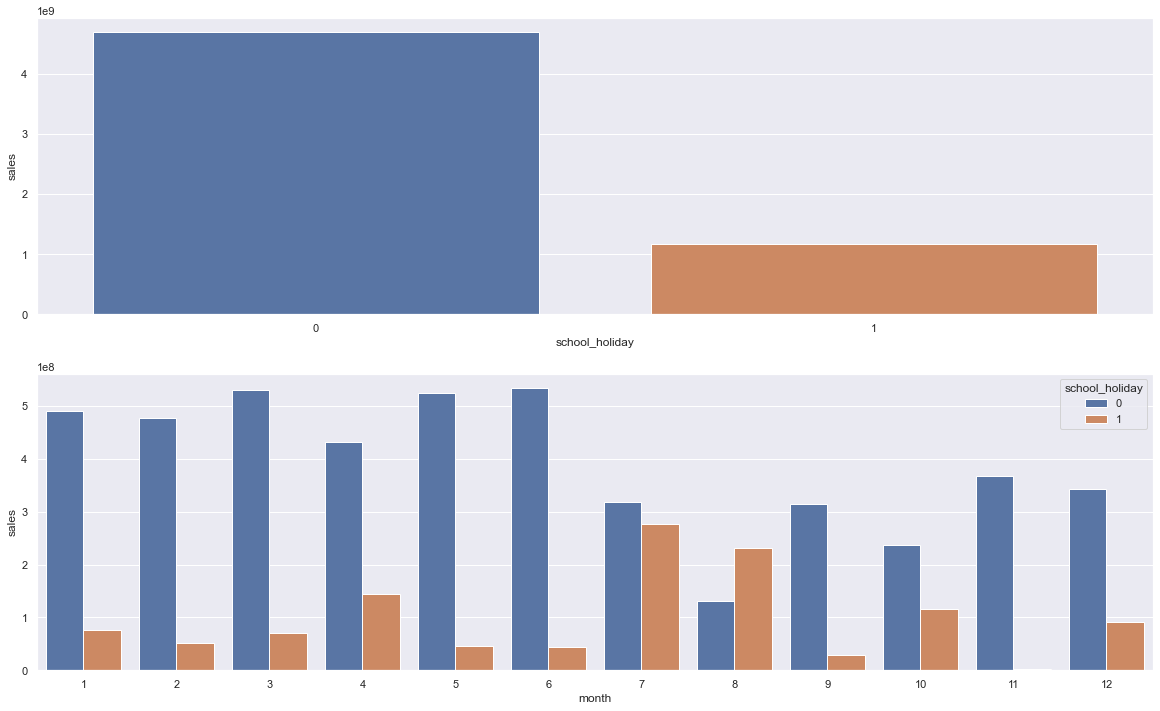

In [40]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()



plt.subplot(2,1,1)
sns.barplot(data= aux1, x='school_holiday', y='sales')

plt.subplot(2,1,2)
sns.barplot(data= aux2, x='month', y='sales', hue='school_holiday');

In July and August have an invertion of pattern because it's summer vacation

### 4.2.1. Hipothesys Summary

In [41]:
tab=[['Hypothesis', 'Conclusion', 'Relevance'],
     ['H1', 'False', 'Low'],
     ['H2', 'False', 'Medium'],
     ['H3', 'False', 'Medium'],
     ['H4', 'False', 'Low'],
     ['H5', 'False', 'Low'],
     ['H6', 'False', 'Low'],
     ['H7', 'False', 'Medium'],
     ['H8', 'False', 'High'],
     ['H9', 'False', 'High'],
     ['H10', 'True', 'High'],
     ['H11', 'True', 'High'],
     ['H12', 'True', 'Low']
]

In [42]:
print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            False         Low
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3. Multivariate analysis 

### 4.3.1. Numerical Attributes 

<AxesSubplot:>

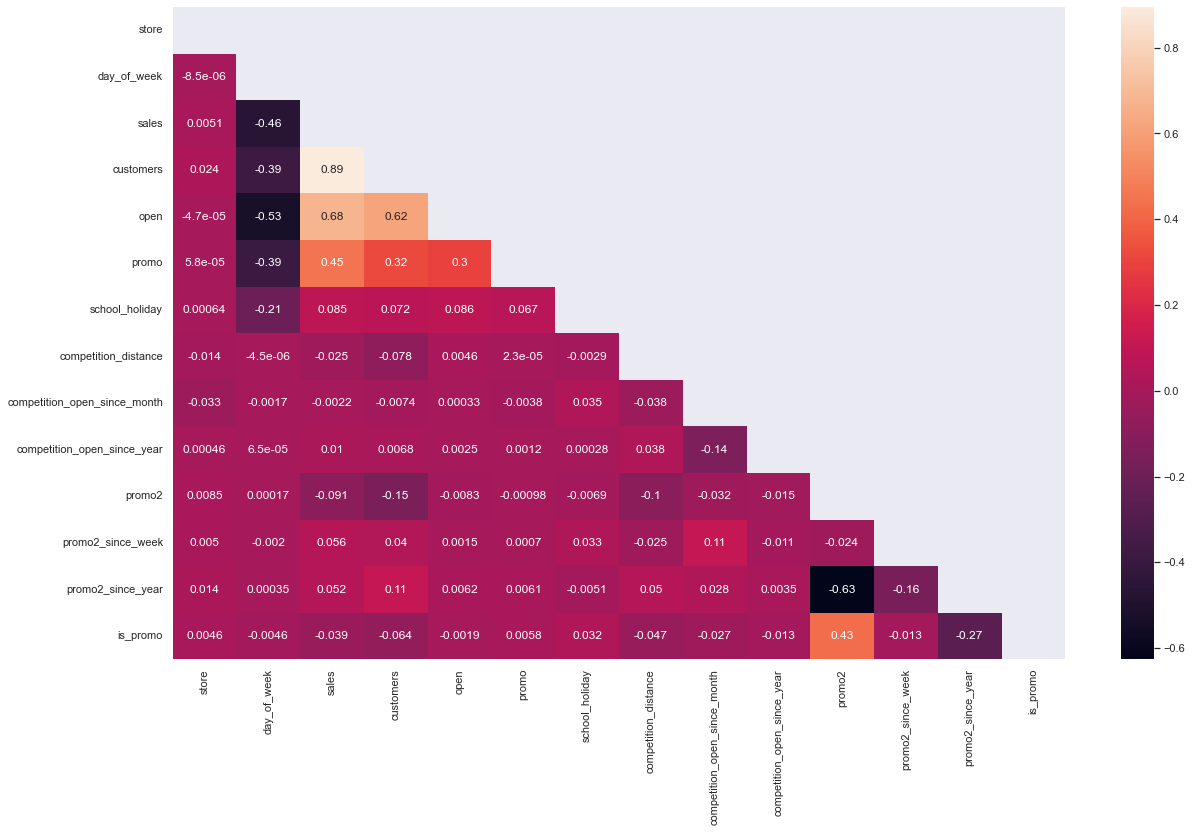

In [43]:
correlation = num_attributes.corr(method='pearson')

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(correlation)


sns.heatmap(correlation, annot=True, mask=matrix)

### 4.3.2. Categoricla Attributes 

#### Cramér's V calculation for categorical variable
$$
V = \sqrt[]{
            \frac{\frac{\chi2}{n}}
                {
                    \min(k - 1,r - 1)
                }
            }
\\[1cm]
where
\\[3mm]
\frac{\chi2}{n} =  \varphi2
$$

#### Bias correction
$$
\tilde V = \sqrt[]{
            \frac{\tilde \varphi^2}
                {
                    \min(\tilde k - 1,\tilde r - 1)
                }
            }
\\[1cm]
where: 
\\[3mm]
\tilde \varphi^2 = \max\left(0,\varphi^2 - \frac{(k-1)(r-1)}{n-1}\right)
\\[1cm]
and
\\[3mm]
\tilde k = k - \frac{(k-1)^2}{n-1}
\\[3mm]
\tilde r = r - \frac{(r-1)^2}{n-1}
$$


In [44]:
#only categorical data
a = df4.select_dtypes(include = 'object')

#calculating Cramer's V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, 9]
              })

# d.set_index([['state_holiday', 'store_type', 'assortment']])
d = d.set_index(d.columns)

<AxesSubplot:>

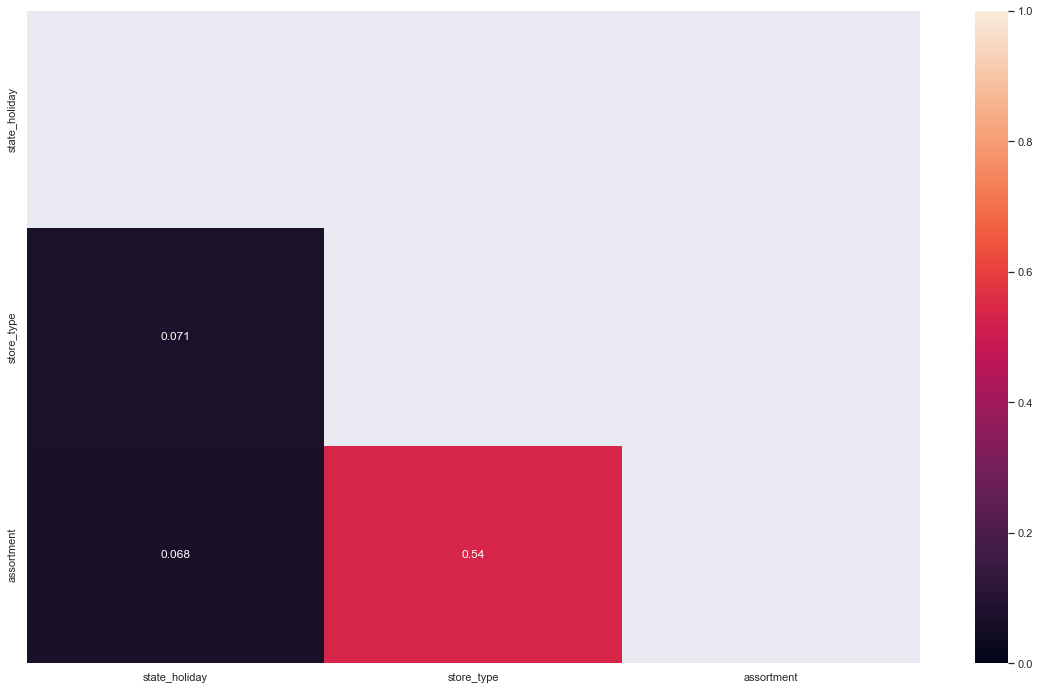

In [45]:
d
matrix = np.triu(d)

sns.heatmap(d, annot=True, vmin=0,vmax = 1, mask=matrix)

In [46]:
df5 = df4.copy()